## Fetching Image and Watermark

In [31]:
import cv2
from scipy.fftpack import dct, idct, dctn, idctn
import matplotlib.pyplot as plt
import numpy as np
import random
import math

In [32]:
imageOriginal = cv2.imread('images/cover.png')
image = imageOriginal.copy()
watermark = cv2.imread('images/iitbbs_logo.jpeg')

print("image shape - ", image.shape)
print("watermark shape - ", watermark.shape)

blksz = 8
step = 0

while True:
  step = ((image.shape[0]*image.shape[1]*image.shape[2])//(blksz*blksz))//(watermark.shape[0]*watermark.shape[1]*watermark.shape[2]*8)
  if step == 0:
    blksz -= 1
  else:
    break

print("block size - ", blksz)
print("step - ", step)
if step == 0:
  print("Image too small for watermark")
  exit()

key = str(blksz) + str(random.randint(1000,9999))
print("key - ", key)

curRandom = int(key[1:])
random.seed(curRandom)
curRandom = random.randint(blksz, step*blksz)
print("curRandom - ", curRandom)

watermarkStr = "".join(format(i, '08b') for i in watermark.flatten())
print("watermark length - ",len(watermarkStr))

def putWatermark(tempDct, val):
  if int((tempDct//10)%2) != int(val):
    tempDct += 10
  tempDct = str(tempDct)
  tempDct = tempDct[:tempDct.find(".")-1] + "5" + tempDct[tempDct.find("."):]
  return float(tempDct)

image shape -  (763, 763, 3)
watermark shape -  (23, 25, 3)
block size -  8
step -  1
key -  84714
curRandom -  8
watermark length -  13800


## Hiding the watermark

In [33]:
b = 0
z = 0
a = 0
for x in watermarkStr:
  tempDct = dctn(image[b:b+blksz, a:a+blksz, z], norm="ortho")
  tempDct[0,0] = putWatermark(tempDct[0,0], x)
  newBlock = idctn(tempDct, norm="ortho")
  image[b:b+blksz, a:a+blksz, z] = np.round(newBlock)
  a += step*blksz
  random.seed(curRandom)
  curRandom = random.randint(blksz, step*blksz)
  if a >= len(image[0]) - blksz:
    a = 0
    b += blksz
    if b >= len(image) - blksz:
      a = 0
      b = 0
      z += 1
      if z >= len(image[0][0]):
        print("Size full")
        break

cv2.imwrite('watermarkedImage.png', image)

True

## Displaying the watermarked image and the original image

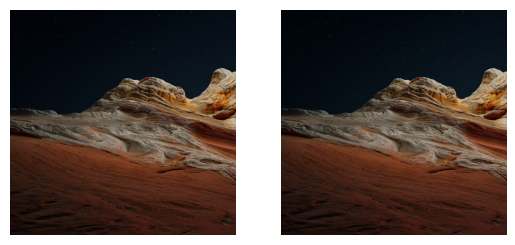

In [34]:
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(cv2.cvtColor(imageOriginal, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


## Decoding - Fetching the watermarked image

In [35]:
image2 = cv2.imread('watermarkedImage.png', cv2.IMREAD_UNCHANGED)

# key = "83456"
curRandom = int(key[1:])
random.seed(curRandom)
blksz = int(key[0])

print("curRandom - ", curRandom)

def getWatermark(tempDct):
  return int(tempDct//10)%2

def getwatermark2d(watermarkStr):
  i=0
  watermarkStr2 = "".join('1' if i=='1' else '0' for i in watermarkStr)
  watermark2d = []
  while i<len(watermarkStr2):
    watermark2d.append([int(watermarkStr2[i:i+8], 2)])
    i+=8
  watermark2d = np.array(watermark2d).reshape(watermark.shape)
  return watermark2d

curRandom -  4714


## PSNR value

In [36]:
def psnr(image1, image2):
  mse = np.mean((image1 - image2) ** 2)
  if mse == 0:
    return 100
  PIXEL_MAX = 255.0
  return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

## NCC value

In [37]:
def nccValue(image1, image2):
  image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
  image2 = np.float32(image2)
  image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
  image1_norm = (image1 - np.mean(image1))/np.std(image1)
  image2_norm = (image2 - np.mean(image2))/np.std(image2)

  return np.sum(image1_norm * image2_norm) / np.sqrt(np.sum(image1_norm ** 2) * np.sum(image2_norm ** 2))

## Attack 1 - Cropping

In [38]:
def croppingAttack(image2):
  x = int(0.05*image2.shape[0])
  y = int(0.05*image2.shape[1])
  image3 = image2.copy()
  image3[:x, :, :] = 0
  image3[:, :y, :] = 0
  image3[-x:, :, :] = 0
  image3[:, -y:, :] = 0
  return image3


## Attack 2 - Salt and Pepper Noise

In [39]:
def saltAndPepperAttack(image2):
  import time
  random.seed(time.time())
  image3 = image2.copy()
  i = random.randint(0, image2.shape[0])
  j = random.randint(0, image2.shape[1])

  cnt = int(0.002*(image2.shape[0])*(image2.shape[1]))
  while cnt > 0:
    image3[i:i+4, j:j+4, :] = 0 if random.randint(0, 1) else 255
    i = random.randint(0, image2.shape[0])
    j = random.randint(0, image2.shape[1])
    cnt -= 1
  return image3

## Attack 3 - Median Filtering Noise Attack

In [40]:
def medianFiltering(image2, ksize):
  image3 = cv2.medianBlur(image2, ksize).copy()
  return image3

## Attack 4 - Scaling

In [41]:
def scalingAttack(image2):
  image3 = image2.copy()
  image3 = cv2.resize(image3, (int(image3.shape[1]*0.85), int(image3.shape[0]*0.85)))
  image3 = cv2.resize(image3, (image2.shape[1], image2.shape[0]))
  return image3

## Decoding function

In [42]:
def decodeWatermark(image3):
  b = 0
  z = 0
  a = 0
  cnt=0
  watermark2 = ""
  for i in range(len(watermarkStr)):
    cnt += 1
    tempDct = dctn(image3[b:b+blksz, a:a+blksz, z], norm="ortho")
    watermark2 += str(getWatermark(tempDct[0,0]))
    curRandom = random.randint(blksz, step*blksz)
    random.seed(curRandom)
    a += step*blksz
    if a >= len(image3[0]) - blksz:
      a = 0
      b += blksz
      if b >= len(image3) - blksz:
        a = 0
        b = 0
        z += 1
        if z >= len(image3[0][0]):
          print("Size full")
          break
  watermark2 = getwatermark2d(watermark2)
  return watermark2

## Plotting the results

In [43]:
def PlotTwoImages(image2, image3, watermark, watermark2):
  plt.figure(figsize=(5,5))
  plt.subplot(2, 2, 1)
  plt.axis("off")
  plt.title("Original Image")
  plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
  plt.subplot(2, 2, 2)
  plt.axis("off")
  plt.title("Attacked Image")
  plt.imshow(cv2.cvtColor(image3.astype(np.uint8), cv2.COLOR_BGR2RGB))
  plt.subplot(2, 2, 3)
  plt.axis("off")
  plt.title("Original Watermark")
  plt.imshow(cv2.cvtColor(watermark.astype(np.uint8), cv2.COLOR_BGR2RGB))
  plt.subplot(2, 2, 4)
  plt.axis("off")
  plt.title("Extracted Watermark")
  plt.imshow(cv2.cvtColor(watermark2.astype(np.uint8), cv2.COLOR_BGR2RGB))
  plt.show()

Without Attack
PSNR 50.30348169860842
NCC 0.9999477835586579


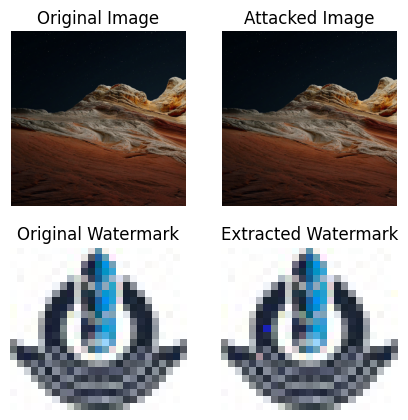

Cropping Attack
NCC 0.7357793543992657


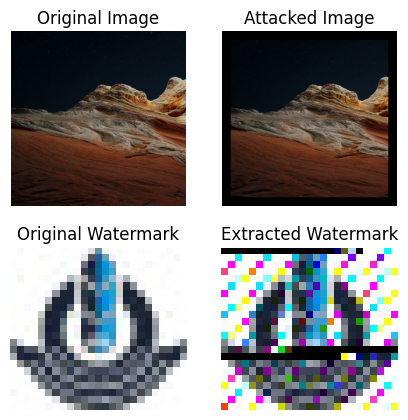

Salt and Pepper Attack
NCC 0.9005957889076683


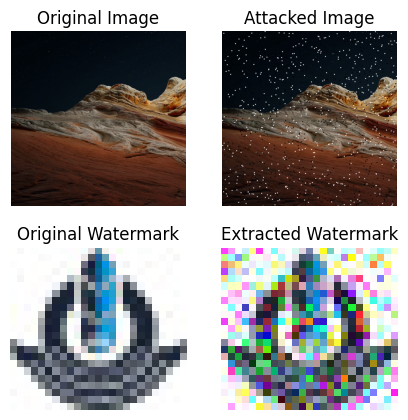

Scaling Attack
NCC 0.82590237045538


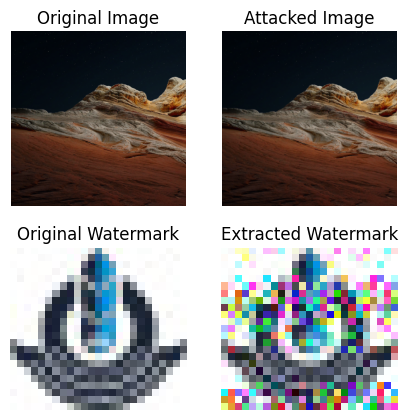

Median Filtering noise Attack
NCC 0.674755877431668


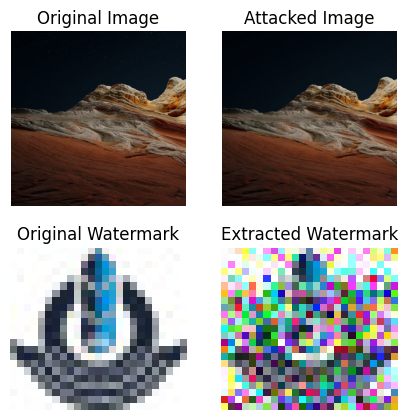

True

In [44]:
print("Without Attack")
print("PSNR",psnr(imageOriginal, image2))
watermark2 = decodeWatermark(image2)
print("NCC",nccValue(watermark, watermark2))
PlotTwoImages(image2, image2, watermark, watermark2)
cv2.imwrite("extractedWatermark.png", watermark2)

print("Cropping Attack")
image3 = croppingAttack(image2)
watermark2 = decodeWatermark(image3)
print("NCC",nccValue(watermark, watermark2))
PlotTwoImages(image2, image3, watermark, watermark2)
cv2.imwrite("cropped.png", watermark2)

print("Salt and Pepper Attack")
image3 = saltAndPepperAttack(image2)
watermark2 = decodeWatermark(image3)
print("NCC",nccValue(watermark, watermark2))
PlotTwoImages(image2, image3, watermark, watermark2)
cv2.imwrite("salt_pepper.png", watermark2)

print("Scaling Attack")
image3 = scalingAttack(image2)
watermark2 = decodeWatermark(image3)
print("NCC",nccValue(watermark, watermark2))
PlotTwoImages(image2, image3, watermark, watermark2)
cv2.imwrite("scaling.png", watermark2)

print("Median Filtering noise Attack")
image3 = medianFiltering(image2, 3)
watermark2 = decodeWatermark(image3)
print("NCC",nccValue(watermark, watermark2))
PlotTwoImages(image2, image3, watermark, watermark2)
cv2.imwrite("median_filtering.png", watermark2)